# Pipeline Evaluation:

This notebook investigates the entire pipeline to see where potential errors are occuring. I will be investigating our complete pipeline step by step on simulation data to see how we are clustering/detecting potential synapses.

## Simulation Data:
Almost the exact same simulation that we used for Precision&Recall as well as Connected Components. I generated a smaller volume size so plots are easier to analyze.  

Description: Validation testing will be performed on a a 50 x 50 x 50 volume. The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~1 micron ^3, or about 139 voxels (assuming the synthetic data here and the real world data have identical resolutions). Pixel intensity distributions are ignored in this simulation because we just want to study how the synapses are being clustered. Therefore, the correct "total" number of synapses is relatively unimportant compared to the ratio of true positives/false positives/ false negatives of our pipeline. In this simulation, synapses make up 8% of the data.

Evaluation: I will be evaluating each step in the pipeline through plot.ly graphs (look at it) and evaluating the final algorithm using Precision and Recall.

### Raw Synthetic Data:

In [1]:
import sys
sys.path.insert(0, '../code/functions/')
import connectLib as cLib
from random import randrange as rand
import itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import math
from cluster import Cluster
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../functions/')
import cv2
import plosLib as pLib
import mouseVis as mv
import tiffIO as tIO
import cPickle as pickle
import hyperReg as hype
from scipy import ndimage


def generatePointSet():
    center = (rand(0, 50), rand(0, 50), rand(0, 50))
    toPopulate = []
    for z in range(-1, 5):
        for y in range(-1, 5):
            for x in range(-1, 5):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 50:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((50, 50, 50))
    myPointSet = set()
    clusterList = []
    for _ in range(rand(60, 100)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
            potentialPointSet = generatePointSet()
            clusterList.append(Cluster(list(potentialPointSet)))
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume, clusterList

testVolume = generateTestVolume()
foreground = testVolume[0]
combinedIm = testVolume[1]
trueClusterList = testVolume[2]



Why Our Simulation is Correct: Real microscopic images of synapses usually contain a majority of background noise and relatively few synapse clusters. As shown above, the generated test volume follows this expectation. 

NOTE: Double check Richard Roth on synapse size (original: .2^3 microns, now 1 micron)

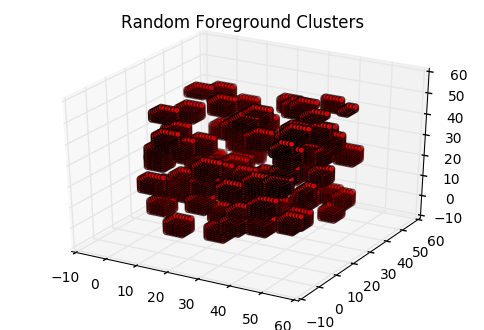

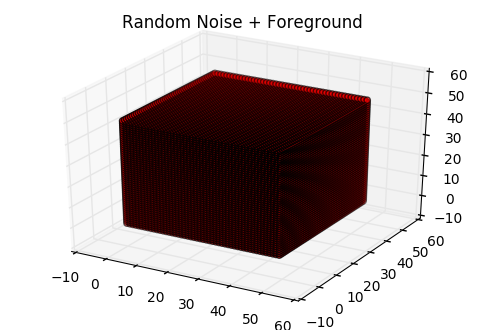

In [2]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

In [3]:
## Getting cluster members for true clusters to plot using plotly.
trueCentroids = []
for cluster in trueClusterList:
    trueCentroids.append(cluster.getCentroid())

trueMembers = []
for cluster in trueClusterList:
    for member in cluster.members:
        trueMembers.append(member)

In [4]:
## Plotting all true cluster members and the centroids of the true positive clusters.
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

In [31]:
trace0 = Scatter3d(
    x=[member[2] for member in trueMembers],
    y=[member[1] for member in trueMembers],
    z=[member[0] for member in trueMembers],
    mode='markers',
    marker=dict(
        size=3,
        color = 'red'
    ),
    opacity=1
)

data = [trace0]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)

## Pipeline Code

In [5]:
import sys
sys.path.insert(0, '../functions/')
import cv2
import plosLib as pLib
import connectLib as cLib
from cluster import Cluster
import mouseVis as mv
import tiffIO as tIO
import cPickle as pickle
import hyperReg as hype
from scipy import ndimage
import matplotlib.pyplot as plt

def analyzeTimepoint(tiffImage, plosNeighborhood, plosLowerZBound, plosUpperZBound, debug=False):
    #finding the clusters after plosPipeline
    plosOut = pLib.pipeline(tiffImage, plosNeighborhood, plosLowerZBound, plosUpperZBound)
    #binarize output of plos lib
    bianOut = cLib.otsuVox(plosOut)
    
    #dilate the output based on neigborhood size
    for i in range(int((plosNeighborhood+plosUpperZBound+plosLowerZBound)/3.)):
        bianOut = ndimage.morphology.binary_dilation(bianOut).astype(int)
    #run connected component
    connectList = cLib.connectedComponents(bianOut)

    if debug:
        print connectList, bianOut

    return connectList

## First Step: PLOS
The plos pipeline is a box filter that degrades away values below a certain intensity value. 

In [8]:
plosOut = pLib.pipeline(combinedIm)

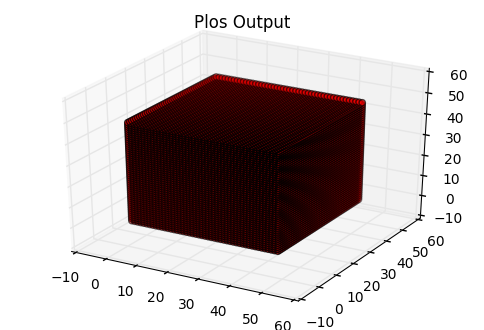

In [18]:
# Evaluating plos output

#displaying the plos output
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = plosOut.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Plos Output')
plt.show()

In [19]:
for z in range(50):
    for y in range(50):
        for x in range(50):
            print plosOut[z][y][x]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


<Container object of 50 artists>

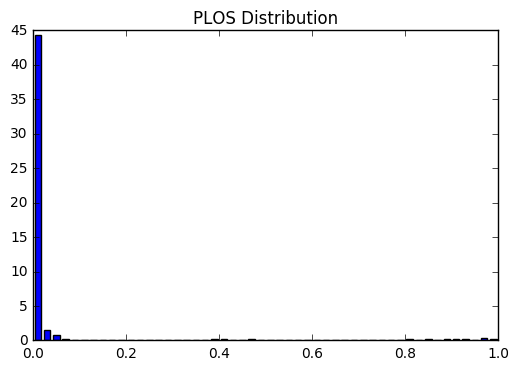

In [23]:
#displaying distribution of plos outputs
fig = plt.figure()
plt.title("PLOS Distribution")
hist, bins = np.histogram(plosOut, bins=50, normed=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width)



In [29]:
#Before trying Otsu's Binarization, I will first trying plotting values above a certain value.
plosMembersAboveThresh = []
thresh = np.percentile(plosOut, 92)
for z in range(50):
    for y in range(50):
        for x in range(50):
            if (plosOut[x][y][z]) >= thresh:
                plosMembersAboveThresh.append([z,y,x])
print plosMembersAboveThresh
print len(plosMembersAboveThresh)

[[1, 24, 20], [1, 24, 21], [1, 25, 20], [1, 25, 24], [1, 26, 20], [1, 26, 24], [1, 33, 48], [1, 34, 47], [1, 35, 47], [1, 36, 47], [1, 42, 7], [1, 43, 7], [1, 43, 8], [1, 43, 9], [1, 43, 10], [1, 43, 11], [1, 43, 12], [1, 44, 7], [1, 44, 8], [1, 44, 9], [1, 44, 10], [1, 44, 11], [1, 44, 12], [1, 45, 7], [1, 45, 8], [1, 45, 9], [1, 45, 10], [1, 45, 11], [1, 45, 12], [1, 46, 7], [1, 46, 8], [1, 46, 9], [1, 46, 10], [1, 46, 11], [1, 46, 12], [1, 47, 7], [1, 47, 11], [2, 23, 21], [2, 24, 20], [2, 24, 21], [2, 24, 22], [2, 24, 23], [2, 24, 24], [2, 24, 25], [2, 25, 20], [2, 25, 21], [2, 25, 22], [2, 25, 23], [2, 25, 24], [2, 25, 25], [2, 26, 20], [2, 26, 21], [2, 26, 22], [2, 26, 23], [2, 26, 24], [2, 26, 25], [2, 26, 39], [2, 26, 40], [2, 26, 41], [2, 26, 44], [2, 27, 20], [2, 27, 21], [2, 27, 22], [2, 27, 23], [2, 27, 24], [2, 27, 25], [2, 27, 39], [2, 27, 40], [2, 27, 41], [2, 27, 42], [2, 27, 43], [2, 27, 44], [2, 28, 20], [2, 28, 21], [2, 28, 39], [2, 28, 40], [2, 28, 41], [2, 28, 42],

In [30]:
#plotting PlOS Members 
trace0 = Scatter3d(
    x=[point[2] for point in plosMembersAboveThresh],
    y=[point[1] for point in plosMembersAboveThresh],
    z=[point[0] for point in plosMembersAboveThresh],
    mode='markers',
    marker=dict(
        size=3,
        
    ),
    opacity=1
)

data = [trace0]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)

In [32]:
# plotting PLOS and True Members:

# Plos Members
trace0 = Scatter3d(
    x=[point[2] for point in plosMembersAboveThresh],
    y=[point[1] for point in plosMembersAboveThresh],
    z=[point[0] for point in plosMembersAboveThresh],
    mode='markers',
    marker=dict(
        size=3,
        
    ),
    opacity=1
)

# True Members
trace1 = Scatter3d(
    x=[member[2] for member in trueMembers],
    y=[member[1] for member in trueMembers],
    z=[member[0] for member in trueMembers],
    mode='markers',
    marker=dict(
        size=3,
        color = 'red'
    ),
    opacity=.3
)

data = [trace0, trace1]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)

In [35]:
#Stronger Thresh?
plosMembersAboveHarshThresh = []
thresh = np.percentile(plosOut, 95)
for z in range(50):
    for y in range(50):
        for x in range(50):
            if (plosOut[x][y][z]) >= thresh:
                plosMembersAboveHarshThresh.append([z,y,x])
print plosMembersAboveHarshThresh
print len(plosMembersAboveHarshThresh)

[[1, 43, 7], [1, 43, 8], [1, 43, 9], [1, 43, 10], [1, 43, 11], [1, 43, 12], [1, 44, 7], [1, 44, 8], [1, 44, 9], [1, 44, 10], [1, 44, 11], [1, 44, 12], [1, 45, 7], [1, 45, 8], [1, 45, 9], [1, 45, 10], [1, 45, 11], [1, 45, 12], [1, 46, 8], [1, 46, 9], [1, 46, 10], [1, 46, 11], [1, 46, 12], [2, 24, 21], [2, 24, 22], [2, 24, 23], [2, 24, 24], [2, 25, 21], [2, 25, 22], [2, 25, 23], [2, 25, 24], [2, 26, 21], [2, 26, 22], [2, 26, 23], [2, 26, 24], [2, 27, 21], [2, 27, 22], [2, 27, 23], [2, 27, 24], [2, 33, 48], [2, 34, 48], [2, 35, 48], [2, 36, 48], [2, 43, 7], [2, 43, 8], [2, 43, 9], [2, 43, 10], [2, 43, 11], [2, 43, 12], [2, 44, 7], [2, 44, 8], [2, 44, 9], [2, 44, 10], [2, 44, 11], [2, 44, 12], [2, 45, 8], [2, 45, 9], [2, 45, 10], [2, 45, 11], [2, 45, 12], [2, 46, 8], [2, 46, 9], [2, 46, 10], [2, 46, 11], [2, 46, 12], [3, 24, 21], [3, 24, 22], [3, 24, 23], [3, 24, 24], [3, 25, 21], [3, 25, 22], [3, 25, 23], [3, 25, 24], [3, 26, 21], [3, 26, 22], [3, 26, 23], [3, 26, 24], [3, 26, 40], [3, 26

In [36]:
# plotting PLOS and True Members:

# Plos Members
trace0 = Scatter3d(
    x=[point[2] for point in plosMembersAboveHarshThresh],
    y=[point[1] for point in plosMembersAboveHarshThresh],
    z=[point[0] for point in plosMembersAboveHarshThresh],
    mode='markers',
    marker=dict(
        size=3,
        
    ),
    opacity=1
)

# True Members
trace1 = Scatter3d(
    x=[member[2] for member in trueMembers],
    y=[member[1] for member in trueMembers],
    z=[member[0] for member in trueMembers],
    mode='markers',
    marker=dict(
        size=3,
        color = 'red'
    ),
    opacity=.3
)

data = [trace0, trace1]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)

## Conclusion:

PLOS is not working at all? The plos clusters seem to be formed randomly at places where NO true cluster even exists. Potentially, relatively bright background spots (~10,000 intensity range) might be avoiding getting degraded by the PLOS pipeline. Some true clusters are also just blanatly ignored. Studying the scatter plot, you can also see examples where two clusters close together actually get degraded into one cluster, which helps contribute to our false negative (recall) value. However, some other clusters are just being completely ignored by PLOS (the entire cluster gets degraded away). 

The two major problems here that require indepth investigation are: 
1. non-edge case synapses are being completely degraded. 
2. Areas where there are clearly no synapses are somehow now populated with multiple synapses from the PLOS pipeline.

